<a href="https://colab.research.google.com/github/marcinwolter/Tracking/blob/master/GNN_Tutorial_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial: GNNs for Particle Tracking

HEP.TrkX group

Steve Farrell, Daniel Murname

*Feb 2020*

In [0]:
# System imports
import os
import sys
from pprint import pprint as pp
from time import time as tt

# External imports
import matplotlib.pyplot as plt
import matplotlib.colors
import numpy as np
import pandas as pd
import seaborn as sns
import torch

In [3]:
print("PyTorch version:",print(torch.__version__),", CUDA version:", torch.version.cuda)

1.4.0
PyTorch version: None , CUDA version: 10.1


In [4]:
!pip install torch-scatter==latest+cu101 torch-sparse==latest+cu101 -f https://s3.eu-central-1.amazonaws.com/pytorch-geometric.com/whl/torch-1.4.0.html
!pip install torch-geometric

Looking in links: https://s3.eu-central-1.amazonaws.com/pytorch-geometric.com/whl/torch-1.4.0.html
     |████████████████████████████████| 10.6MB 1.2MB/s 
     |████████████████████████████████| 9.6MB 73.0MB/s 
     |████████████████████████████████| 143kB 4.8MB/s 
     |████████████████████████████████| 348kB 67.4MB/s 
     |████████████████████████████████| 51kB 8.8MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-1.4.2-cp36-none-any.whl size=224447 sha256=889eef25983da9816d0562ea6f3fe5ed592f934cf0edd0d29d261a7a9d76f6ea
  Stored in directory: /root/.cache/pip/wheels/0f/9d/a3/2de0c1fb436ec76e2942b4216b820589d40bc48395995c3076
  Created wheel for plyfile: filename=plyfile-0.7.1-cp36-none-any.whl size=32828 sha256=8322c49b0a260d4635caa296b5cd532d5656048345e87fd83e538fba5c2288dd
  Stored in directory: /root/.cache/pip/wheels/d6/0d/bf/6d603d81b98604d2ecfd5e99d4ab7c9af664fd5285ab82bbb0
Successfully built torch-geometric plyfile


In [0]:
from torch_geometric.data import Data
from torch_geometric.data import DataLoader
import torch.nn as nn
from torch_scatter import scatter_add
import torch.nn.functional as F

import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from IPython.display import clear_output
from IPython.display import HTML, display

%matplotlib inline

# Get rid of RuntimeWarnings, gross
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

## The Problem

### Toy Data

In [0]:
# Circle parameters
num_layers = 10
height, width = 10, 10
min_curve, max_curve = 15, 50
noise = False
event_size_min, event_size_max = 4, 12 #I.E. The number of true particle tracks
max_angle=(4/6)*np.pi
feature_scale = np.array([10,10])

In [0]:
# Some dumb circle calculations
def y1(x, r, a, sign):
    return sign*np.sqrt(r**2 - a**2) + np.sqrt(r**2 - (x-a)**2)
def y2(x, r, a, sign):
    return sign*np.sqrt(r**2 - a**2) - np.sqrt(r**2 - (x-a)**2)

# Generate random circle / helix parameters
def rand_pars(event_size_min, event_size_max, max_curve, min_curve):
    event_size = int(np.floor(np.random.random(1)*(event_size_max - event_size_min) + event_size_min))
    radii = np.random.random(event_size)*(max_curve - min_curve) + min_curve
    dirs = np.random.random(event_size)*(radii)*2 -radii
    sign_options = np.array([-1,1])
    signs = sign_options[np.rint(np.random.random(event_size)).astype(int)]
    return radii, dirs, signs, event_size

def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

# Generate event data from random parameters
def gen_edge_class(event_size_min, event_size_max, curve_min, curve_max, height, num_layers, max_angle, feature_scale, iter, num_samples):
    
    """ Feed params into randomiser """
    while True:
        radii, dirs, signs, event_size = rand_pars(event_size_min, event_size_max, curve_max, curve_min)
        xys = []
        X = np.empty([3,1])
        x = np.arange(0 + height/num_layers,height + height/num_layers, height/num_layers)
        i = 0
        for r, d, s in zip(radii, dirs, signs):
            y1test = y1(x, r, d, s)
        #     print(y1test, x)
            y2test = y2(x, r, d, s)
            if -2.5 < y1test[0] < 2.5 and not any(np.isnan(y1test)):
                X = np.append(X, np.vstack((y1test, np.array([i]*len(y1test)), x )), axis=1)
                i += 1
            if -2.5 < y2test[0] < 2.5 and not any(np.isnan(y2test)):
                X = np.append(X, np.vstack((y2test, np.array([i]*len(y2test)), x )), axis=1)
                i += 1
        X = X[:,1:].T
        np.random.shuffle(X)

        e = np.array([[i,j] for layer in np.arange(num_layers-1) for i in np.argwhere(X[:,2] == layer+1) for j in np.argwhere(X[:,2] == (layer+2)) if (X[i, 0] - np.tan(max_angle/2) < X[j, 0] < X[i, 0] + np.tan(max_angle/2))]).T.squeeze()
        
        # This handles when no edges were constructed. In that case, the randomisation is a do-over
        try:
            y = np.array([int(i[1] == j[1]) for i,j in zip(X[e[0]], X[e[1]])])    
            break
        except:
            pass
    if iter is not None and num_samples is not None:
        out.update(progress(iter, num_samples))    
    
    X = np.array([X[:,2], X[:,0]]).T / feature_scale

    data = Data(x = torch.from_numpy(X).float(), edge_index = torch.from_numpy(e), y = torch.from_numpy(y), pid = torch.from_numpy(X[:,1]))
    return data


In [8]:
train_size, test_size = 1000, 1000
out = display(progress(0, train_size), display_id=True)
train_dataset = [gen_edge_class(event_size_min, event_size_max, max_curve, min_curve, height, num_layers, max_angle, feature_scale, i, train_size) for i in range(train_size)]
out = display(progress(0, test_size), display_id=True)
test_dataset = [gen_edge_class(event_size_min, event_size_max, max_curve, min_curve, height, num_layers, max_angle, feature_scale, i, test_size) for i in range(test_size)]
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=True)

In [0]:
def plot_toy_graph(event):
    plt.figure(figsize=(10,5))
    x, y = event.x[:,0].numpy(), event.x[:,1].numpy()
    e = event.edge_index.numpy()
#     for i, j in zip(X[e[0]], X[e[1]]):
#         plt.plot([i[0], j[0]], [i[1], j[1]], c='b')
    #     print(i[0], i[2], j[0], j[2])
    plt.plot([x[e[0,:]], x[e[1,:]]], [y[e[0,:]], y[e[1,:]]], c='b')
    plt.scatter(x, y, c='k')
    plt.ylim(-1,1)

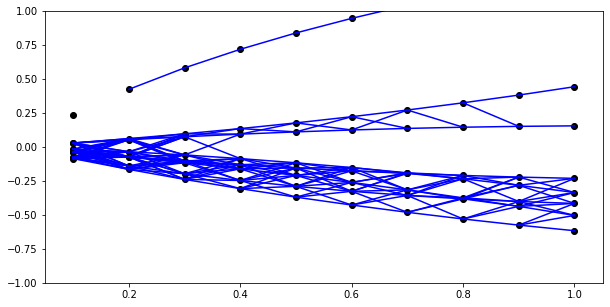

In [10]:
plot_toy_graph(test_dataset[0])

The complexity of the graph depends on the angle cut we put on it. Try increasing max_angle to, say, `(5/6)*np.pi` and the graph should be more busy. The limit is of course `(6/6)*np.pi = pi` where each node will look at the full angle of available possible nodes to form an edge with. While playing with this number, run the next cell to see the proportion of fake edges to true edges (fake/true) on the above graph. This value will be extremely useful later.

In [11]:
print("Fake / True = ", (len(train_dataset[0].y) - train_dataset[0].y.sum().item()) / train_dataset[0].y.sum().item())

Fake / True =  1.3137254901960784


### Real Data

The data from a (good) simulation is much more busy. Let's load a TrackML event and visualise it

In [12]:
!pip install git+https://github.com/LAL/trackml-library

  Cloning https://github.com/LAL/trackml-library to /tmp/pip-req-build-w98xf33u
  Running command git clone -q https://github.com/LAL/trackml-library /tmp/pip-req-build-w98xf33u
  Created wheel for trackml: filename=trackml-3-py2.py3-none-any.whl size=13512 sha256=c07768d307217595801eedcf5a60ee5de274fff9aa1eb01b28033da46827fceb
  Stored in directory: /tmp/pip-ephem-wheel-cache-rhuz1624/wheels/62/a8/3a/330c0e606bd185f850e7aec01df4607aa3df395945cf74905c
Successfully built trackml


In [0]:
import trackml.dataset

def calc_dphi(phi1, phi2):
    """Computes phi2-phi1 given in range [-pi,pi]"""
    dphi = phi2 - phi1
    dphi[dphi > np.pi] -= 2*np.pi
    dphi[dphi < -np.pi] += 2*np.pi
    return dphi

def select_hits(hits, truth, particles, pt_min=0):
    # Barrel volume and layer ids
    vlids = [(8,2), (8,4), (8,6), (8,8),
             (13,2), (13,4), (13,6), (13,8),
             (17,2), (17,4)]
    n_det_layers = len(vlids)
    # Select barrel layers and assign convenient layer number [0-9]
    vlid_groups = hits.groupby(['volume_id', 'layer_id'])
    hits = pd.concat([vlid_groups.get_group(vlids[i]).assign(layer=i)
                      for i in range(n_det_layers)])
    # Calculate particle transverse momentum
    pt = np.sqrt(particles.px**2 + particles.py**2)
    # True particle selection.
    # Applies pt cut, removes all noise hits.
    particles = particles[pt > pt_min]
    truth = (truth[['hit_id', 'particle_id']]
             .merge(particles[['particle_id']], on='particle_id'))
    # Calculate derived hits variables
    r = np.sqrt(hits.x**2 + hits.y**2)
    phi = np.arctan2(hits.y, hits.x)
    # Select the data columns we need
    hits = (hits[['hit_id', 'z', 'layer']]
            .assign(r=r, phi=phi)
            .merge(truth[['hit_id', 'particle_id']], on='hit_id'))
    # Remove duplicate hits
    hits = hits.loc[
        hits.groupby(['particle_id', 'layer'], as_index=False).r.idxmin()
    ]
    return hits    

def select_segments(hits1, hits2, phi_slope_max, z0_max):
    """
    Construct a list of selected segments from the pairings
    between hits1 and hits2, filtered with the specified
    phi slope and z0 criteria.
    Returns: pd DataFrame of (index_1, index_2), corresponding to the
    DataFrame hit label-indices in hits1 and hits2, respectively.
    """
    # Start with all possible pairs of hits
    keys = ['evtid', 'r', 'phi', 'z']
    hit_pairs = hits1[keys].reset_index().merge(
        hits2[keys].reset_index(), on='evtid', suffixes=('_1', '_2'))
    # Compute line through the points
    dphi = calc_dphi(hit_pairs.phi_1, hit_pairs.phi_2)
    dz = hit_pairs.z_2 - hit_pairs.z_1
    dr = hit_pairs.r_2 - hit_pairs.r_1
    phi_slope = dphi / dr
    z0 = hit_pairs.z_1 - hit_pairs.r_1 * dz / dr
    # Filter segments according to criteria
    good_seg_mask = (phi_slope.abs() < phi_slope_max) & (z0.abs() < z0_max)
    return hit_pairs[['index_1', 'index_2']][good_seg_mask]

In [0]:
# Geometric and physics cuts
pt_min = 1
phi_slope_max = .001
z0_max = 200

# Graph features and scale
feature_names = ['r', 'phi', 'z']
feature_scale = np.array([1000., np.pi, 1000.])

In [0]:
def build_event(event_file, pt_min, phi_slope_max, z0_max, feature_names, feature_scale):
    hits, particles, truth = trackml.dataset.load_event(
        event_file, parts=['hits', 'particles', 'truth'])
    hits = select_hits(hits, truth, particles, pt_min=pt_min).assign(evtid=int(event_file[-9:]))
    
    # Define adjacent layers
    n_det_layers = 10
    l = np.arange(n_det_layers)
    layer_pairs = np.stack([l[:-1], l[1:]], axis=1)
    
    layer_groups = hits.groupby('layer')
    segments = []
    for (layer1, layer2) in layer_pairs:
        # Find and join all hit pairs
        try:
            hits1 = layer_groups.get_group(layer1)
            hits2 = layer_groups.get_group(layer2)
        # If an event has no hits on a layer, we get a KeyError.
        # In that case we just skip to the next layer pair
        except KeyError as e:
            logging.info('skipping empty layer: %s' % e)
            continue
        # Construct the segments
        segments.append(select_segments(hits1, hits2, phi_slope_max, z0_max))
        # Combine segments from all layer pairs
    segments = pd.concat(segments)
    
    X = (hits[feature_names].values / feature_scale).astype(np.float32)
    n_edges = len(segments)
    n_hits = len(hits)
    
    pid1 = hits.particle_id.loc[segments.index_1].values
    pid2 = hits.particle_id.loc[segments.index_2].values
    y = np.zeros(n_edges, dtype=np.float32)
    y[:] = (pid1 == pid2)
    
    hit_idx = pd.Series(np.arange(n_hits), index=hits.index)
    seg_start = hit_idx.loc[segments.index_1].values
    seg_end = hit_idx.loc[segments.index_2].values
    
    e = np.vstack([seg_start, seg_end])
    
    return X, e, y

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
event_file = "/content/drive/My Drive/GNN Tutorial/train_100_events/event000001000"

In [0]:
X, e, y = build_event(event_file, pt_min, phi_slope_max, z0_max, feature_names, feature_scale)

In [0]:
def plot_trackml_graph(X, e, feature_scale):
    X = X * feature_scale
    x = X[:,0] * np.cos(X[:,1])
    y = X[:,0] * np.sin(X[:,1])
    plt.figure(figsize=(15,15))
    plt.plot([x[e[0,:]], x[e[1,:]]], [y[e[0,:]], y[e[1,:]]], c='b')
    plt.scatter(x, y, c='k')
#     plt.ylim(-10,10)

CPU times: user 7.3 s, sys: 178 ms, total: 7.48 s
Wall time: 7.47 s


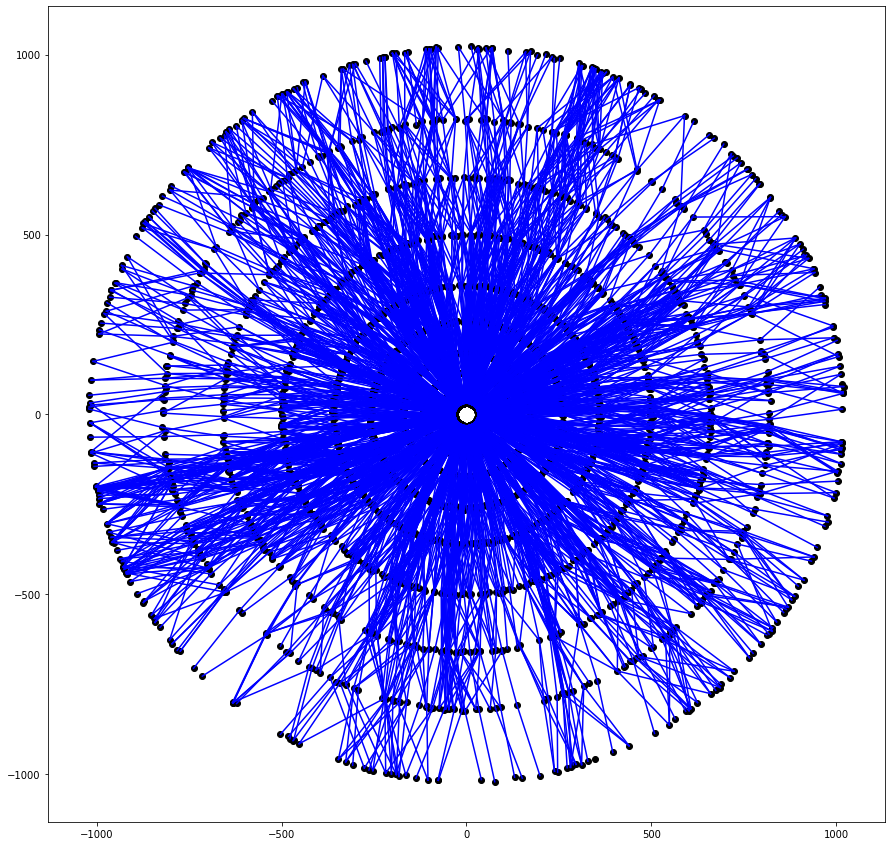

In [20]:
%%time
plot_trackml_graph(X, e, feature_scale)

## A Simple GNN

### Message Passing GNN

We can write out the full GNN as a class `MPNN_Network`. One can see its behaviour as:
1. Encode (x,y) features as hidden features with an N-layer MLP called `node_encoder`
2. Concatenate these along each edge, and feed the concatenated features into another MLP called `edge_network`
3. Sum the output of `edge_classifier` at each node (that is, each node receives the sum of the "messages" of all connecting edges). This sum is fed into `node_network`
4. Add the hidden features to the previous iteration (this helps to preserve information between messages)
5. Repeat (2) --> (4) n_graph_iters times
6. After the message passing loop, pass the features of each edge through an output classifier network called `edge_classifier`

In [0]:
def make_mlp(input_size, sizes,
             hidden_activation='ReLU',
             output_activation='ReLU',
             layer_norm=False):
    """Construct an MLP with specified fully-connected layers."""
    hidden_activation = getattr(nn, hidden_activation)
    if output_activation is not None:
        output_activation = getattr(nn, output_activation)
    layers = []
    n_layers = len(sizes)
    sizes = [input_size] + sizes
    # Hidden layers
    for i in range(n_layers-1):
        layers.append(nn.Linear(sizes[i], sizes[i+1]))
        if layer_norm:
            layers.append(nn.LayerNorm(sizes[i+1]))
        layers.append(hidden_activation())
    # Final layer
    layers.append(nn.Linear(sizes[-2], sizes[-1]))
    if output_activation is not None:
        if layer_norm:
            layers.append(nn.LayerNorm(sizes[-1]))
        layers.append(output_activation())
    return nn.Sequential(*layers)

class MPNN_Network(nn.Module):
    """
    A message-passing graph network which takes a graph with:
    - bi-directional edges
    - node features, no edge features

    and applies the following modules:
    - a graph encoder (no message passing)
    - recurrent edge and node networks
    - an edge classifier
    """

    def __init__(self, input_dim, hidden_node_dim, hidden_edge_dim, in_layers, node_layers, edge_layers,
                 n_graph_iters=1, layer_norm=True):
        super(MPNN_Network, self).__init__()
        self.n_graph_iters = n_graph_iters

        # The node encoder transforms input node features to the hidden space
        self.node_encoder = make_mlp(input_dim, [hidden_node_dim]*in_layers)

        # The edge network computes new edge features from connected nodes
        self.edge_network = make_mlp(2*hidden_node_dim,
                                     [hidden_edge_dim]*edge_layers,
                                     layer_norm=layer_norm)

        # The node network computes new node features
        self.node_network = make_mlp(hidden_node_dim + hidden_edge_dim,
                                     [hidden_node_dim]*node_layers,
                                     layer_norm=layer_norm)

        # The edge classifier computes final edge scores
        self.edge_classifier = make_mlp(2*hidden_node_dim,
                                        [hidden_edge_dim, 1],
                                        output_activation=None)

    def forward(self, data):
        # Make every edge bi-directional
        send_idx = torch.cat([data.edge_index[0], data.edge_index[1]], dim=0)
        recv_idx = torch.cat([data.edge_index[1], data.edge_index[0]], dim=0)

        # Encode the graph features into the hidden space
        x = self.node_encoder(data.x)

        # Loop over graph iterations
        for i in range(self.n_graph_iters):

            # Previous hidden state
            x0 = x

            # Compute new edge features
            edge_inputs = torch.cat([x[send_idx], x[recv_idx]], dim=1)
            e = self.edge_network(edge_inputs)

            # Sum edge features coming into each node
            aggr_messages = scatter_add(e, recv_idx, dim=0, dim_size=x.shape[0])

            # Compute new node features
            node_inputs = torch.cat([x, aggr_messages], dim=1)
            x = self.node_network(node_inputs)

            # Residual connection
            x = x + x0

        # Compute final edge scores; use original edge directions only
        start_idx, end_idx = data.edge_index
        clf_inputs = torch.cat([x[start_idx], x[end_idx]], dim=1)
        return self.edge_classifier(clf_inputs).squeeze(-1)

Build a version of the model and print it out.

In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
m_configs = {"input_dim": 2, "hidden_node_dim": 64, "hidden_edge_dim": 64, "in_layers": 2, "node_layers": 4, "edge_layers": 4, "n_graph_iters": 1, "layer_norm": True}
model = MPNN_Network(**m_configs).to(device)
model

MPNN_Network(
  (node_encoder): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
  )
  (edge_network): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=64, bias=True)
    (4): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=64, bias=True)
    (7): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (8): ReLU()
    (9): Linear(in_features=64, out_features=64, bias=True)
    (10): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (11): ReLU()
  )
  (node_network): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_feature

### Training on Toy Data

In [0]:
def train(model, train_loader, optimizer):
    correct = 0
    total = 0
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        data = batch.to(device)
        pred = model(data)
        loss = F.binary_cross_entropy_with_logits(pred.float(), data.y.float(), pos_weight=torch.tensor(weight))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        correct += ((pred > 0.5) == (data.y > 0.5)).sum().item()
        total += len(pred)
    acc = correct/total
    return acc, total_loss

def evaluate(model, test_loader):
    correct = 0
    total = 0
    total_loss = 0
    for batch in test_loader:
        data = batch.to(device)
        pred = model(data)
        loss = F.binary_cross_entropy_with_logits(pred.float(), data.y.float(), pos_weight=torch.tensor(weight))
        total_loss += loss.item()
        correct += ((pred > 0.5) == (data.y > 0.5)).sum().item()
        total += len(pred)
    acc = correct/total
    return acc, total_loss

In [0]:
t_loss_v = []
t_acc_v = []
v_loss_v = []
v_acc_v = []
ep = 0

We set a weight value that is more or less the (fake / true) ratio found above. This forces the loss function to punish incorrectly classified true edges more severely. It rebalances the distribution as if there was a 1:1 true:fake ratio.

In [25]:
weight = 2

m_configs = {"input_dim": 2, "hidden_node_dim": 16, "hidden_edge_dim": 16, "in_layers": 1, "node_layers": 2, "edge_layers": 2, "n_graph_iters": 6, "layer_norm": True}
model = MPNN_Network(**m_configs).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-3, amsgrad=True)

for epoch in range(200):
    ep += 1  
    model.train()
    acc, total_loss = train(model, train_loader, optimizer)
    t_loss_v.append(total_loss)
    t_acc_v.append(acc)

    model.eval()
    acc, total_loss = evaluate(model, test_loader)
    v_loss_v.append(total_loss)
    v_acc_v.append(acc)

    print('Epoch: {}, Accuracy: {:.4f}'.format(ep, acc))

Epoch: 1, Accuracy: 0.7334
Epoch: 2, Accuracy: 0.7423
Epoch: 3, Accuracy: 0.7430
Epoch: 4, Accuracy: 0.7439
Epoch: 5, Accuracy: 0.7443
Epoch: 6, Accuracy: 0.7424
Epoch: 7, Accuracy: 0.7464
Epoch: 8, Accuracy: 0.7488
Epoch: 9, Accuracy: 0.7504
Epoch: 10, Accuracy: 0.7520
Epoch: 11, Accuracy: 0.7528
Epoch: 12, Accuracy: 0.7555
Epoch: 13, Accuracy: 0.7587
Epoch: 14, Accuracy: 0.7625
Epoch: 15, Accuracy: 0.7662
Epoch: 16, Accuracy: 0.7677
Epoch: 17, Accuracy: 0.7725
Epoch: 18, Accuracy: 0.7751
Epoch: 19, Accuracy: 0.7756
Epoch: 20, Accuracy: 0.7773
Epoch: 21, Accuracy: 0.7783
Epoch: 22, Accuracy: 0.7773
Epoch: 23, Accuracy: 0.7807
Epoch: 24, Accuracy: 0.7816
Epoch: 25, Accuracy: 0.7855
Epoch: 26, Accuracy: 0.7887
Epoch: 27, Accuracy: 0.7943
Epoch: 28, Accuracy: 0.7949
Epoch: 29, Accuracy: 0.8031
Epoch: 30, Accuracy: 0.8075
Epoch: 31, Accuracy: 0.8116
Epoch: 32, Accuracy: 0.8173
Epoch: 33, Accuracy: 0.8212
Epoch: 34, Accuracy: 0.8203
Epoch: 35, Accuracy: 0.8306
Epoch: 36, Accuracy: 0.8365
E

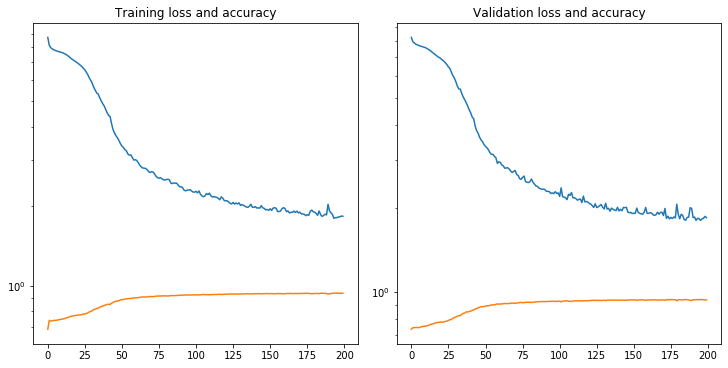

In [26]:
fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(10, 5))
axs[0].plot(np.arange(len(t_loss_v)), t_loss_v, np.arange(len(t_acc_v)), t_acc_v)
axs[0].set_title("Training loss and accuracy")
axs[0].set_yscale("log")
axs[1].plot(np.arange(len(v_loss_v)), v_loss_v, np.arange(len(v_acc_v)), v_acc_v)
axs[1].set_title("Validation loss and accuracy")
axs[1].set_yscale("log")

### Did it work?

Running the above with 1 graph iteration gives me about 90% accuracy in 200 epochs.

The best performance that I can get with some simple manual tuning is around 95% accuracy. We can improve the efficiency at the cost of purity by raising the weight on true edges, but the accuracy won't significantly improve. In general, the biggest changes were from increasing the width (i.e. the number of dimensions) of the hidden layers. We can visualise the performance on a particular graph, colouring true positives black, false positives red, true negatives a transparent black, and false negatives in blue.

In [0]:
def plot_toy_classified(event, preds, cut=0.5):
    
    plt.figure(figsize=(10,5))
    x, y = event.x[:,0].numpy(), event.x[:,1].numpy()
    edges = event.edge_index.numpy()
    labels = event.y
    plt.scatter(x, y, c='k')
    
    preds = preds.detach().numpy()
    
    for j in range(len(labels)):
        
        # False negatives
        if preds[j] < cut and labels[j].item() > cut:
            plt.plot([x[edges[0,j]], x[edges[1,j]]],
                     [y[edges[0,j]], y[edges[1,j]]],
                     '--', c='b')

        # False positives
        if preds[j] > cut and labels[j].item() < cut:
            plt.plot([x[edges[0,j]], x[edges[1,j]]],
                     [y[edges[0,j]], y[edges[1,j]]],
                     '-', c='r', alpha=preds[j])

        # True positives
        if preds[j] > cut and labels[j].item() > cut:
            plt.plot([x[edges[0,j]], x[edges[1,j]]],
                     [y[edges[0,j]], y[edges[1,j]]],
                     '-', c='k', alpha=preds[j])
                
        # True negatives
        if preds[j] < cut and labels[j].item() < cut:
            plt.plot([x[edges[0,j]], x[edges[1,j]]],
                     [y[edges[0,j]], y[edges[1,j]]],
                     '-', c='k', alpha=preds[j])

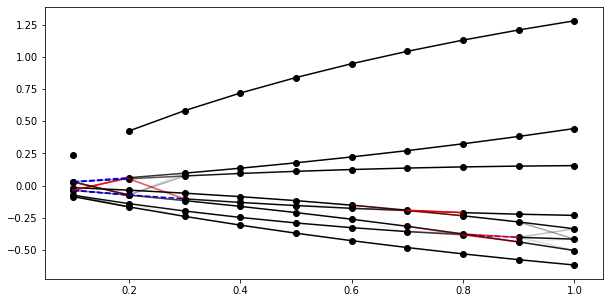

In [28]:
data = test_loader.dataset[0].to(device)
preds = torch.sigmoid(model(data)).to('cpu')
plot_toy_classified(data.to('cpu'), preds, cut = 0.6)

So we can see that it's working quite well. Few missed true edges, and few misclassified fake edges. The ratio of false positives to false negatives (which can be defined with efficiency and purity) is controlled by the cut we put on the prediction score. 

### The effect of Message Passing

In this simple example, the message passing does not do a huge amount. Going from 1 iteration to 6 iterations improves the accuracy to around 93% (from 90%). This improvement is washed out with more hidden dimensions, as one can see from the below set of tests. Try playing with more hidden node and edge dimensions (e.g. 64) and see if the message passing iterations can improve the performance.

Epoch: 1, Accuracy: 0.6634
Epoch: 2, Accuracy: 0.7222
Epoch: 3, Accuracy: 0.7295
Epoch: 4, Accuracy: 0.7377
Epoch: 5, Accuracy: 0.7402
Epoch: 6, Accuracy: 0.7413
Epoch: 7, Accuracy: 0.7417
Epoch: 8, Accuracy: 0.7428
Epoch: 9, Accuracy: 0.7417
Epoch: 10, Accuracy: 0.7433
Epoch: 11, Accuracy: 0.7461
Epoch: 12, Accuracy: 0.7456
Epoch: 13, Accuracy: 0.7476
Epoch: 14, Accuracy: 0.7509
Epoch: 15, Accuracy: 0.7527
Epoch: 16, Accuracy: 0.7540
Epoch: 17, Accuracy: 0.7535
Epoch: 18, Accuracy: 0.7561
Epoch: 19, Accuracy: 0.7588
Epoch: 20, Accuracy: 0.7612
Epoch: 21, Accuracy: 0.7595
Epoch: 22, Accuracy: 0.7662
Epoch: 23, Accuracy: 0.7602
Epoch: 24, Accuracy: 0.7650
Epoch: 25, Accuracy: 0.7663
Epoch: 26, Accuracy: 0.7608
Epoch: 27, Accuracy: 0.7671
Epoch: 28, Accuracy: 0.7611
Epoch: 29, Accuracy: 0.7651
Epoch: 30, Accuracy: 0.7674
Epoch: 31, Accuracy: 0.7675
Epoch: 32, Accuracy: 0.7672
Epoch: 33, Accuracy: 0.7659
Epoch: 34, Accuracy: 0.7674
Epoch: 35, Accuracy: 0.7673
Epoch: 36, Accuracy: 0.7681
E

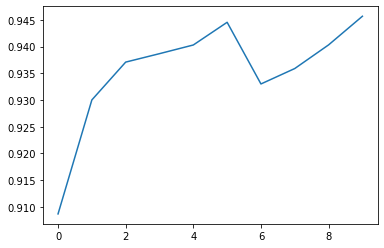

In [29]:
t_loss_v = []
t_acc_v = []
v_loss_v = []
v_acc_v = []
ep = 0
best_acc = np.zeros(10)
for i in range(1,11):
    m_configs = {"input_dim": 2, "hidden_node_dim": 16, "hidden_edge_dim": 16, "in_layers": 1, "node_layers": 2, "edge_layers": 2, "n_graph_iters": i, "layer_norm": True}
    model = MPNN_Network(**m_configs).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-3, amsgrad=True)
    for epoch in range(200):
        ep += 1  
        model.train()
        acc, total_loss = train(model, train_loader, optimizer)
        t_loss_v.append(total_loss)
        t_acc_v.append(acc)

        model.eval()
        acc, total_loss = evaluate(model, test_loader)
        if acc > best_acc[i-1]: best_acc[i-1] = acc
        v_loss_v.append(total_loss)
        v_acc_v.append(acc)

        print('Epoch: {}, Accuracy: {:.4f}'.format(ep, acc))
plt.plot(np.arange(len(best_acc)), best_acc)

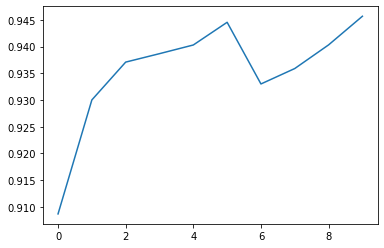

In [30]:
plt.plot(np.arange(len(best_acc)), best_acc)

## Moving to "Real" Data

We need to create a dataset from the TrackML data, which may take a little while...

In [0]:
def prepare_event(event_file, pt_min, phi_slope_max, z0_max, feature_names, feature_scale, iter=None, num_samples=None):
    print("Preparing",event_file)
    X, e, y = build_event(event_file, pt_min, phi_slope_max, z0_max, feature_names, feature_scale)
    data = Data(x = torch.from_numpy(X).float(), edge_index = torch.from_numpy(e), y = torch.from_numpy(y))

    if iter is not None and num_samples is not None:
        out.update(progress(iter, num_samples))    

    return data

In [0]:
input_dir = "/content/drive/My Drive/GNN Tutorial/train_100_events/"
all_events = os.listdir(input_dir)
all_events = [input_dir + event[:14] for event in all_events]

Build the graphs. This will take less than 5 minutes. I hope.

In [33]:
train_size, test_size = 95, 5
out = display(progress(0, train_size), display_id=True)
train_dataset = [prepare_event(event_file, pt_min, phi_slope_max, z0_max, feature_names, feature_scale, iter, train_size) for (event_file, iter) in zip(all_events[:train_size], range(train_size))]
out = display(progress(0, test_size), display_id=True)
test_dataset = [prepare_event(event_file, pt_min, phi_slope_max, z0_max, feature_names, feature_scale, iter, test_size) for (event_file, iter) in zip(all_events[-test_size:], range(test_size))]
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=True)

Preparing /content/drive/My Drive/GNN Tutorial/train_100_events/event000001000
Preparing /content/drive/My Drive/GNN Tutorial/train_100_events/event000001002
Preparing /content/drive/My Drive/GNN Tutorial/train_100_events/event000001003
Preparing /content/drive/My Drive/GNN Tutorial/train_100_events/event000001006
Preparing /content/drive/My Drive/GNN Tutorial/train_100_events/event000001005
Preparing /content/drive/My Drive/GNN Tutorial/train_100_events/event000001001
Preparing /content/drive/My Drive/GNN Tutorial/train_100_events/event000001000
Preparing /content/drive/My Drive/GNN Tutorial/train_100_events/event000001009
Preparing /content/drive/My Drive/GNN Tutorial/train_100_events/event000001010
Preparing /content/drive/My Drive/GNN Tutorial/train_100_events/event000001007
Preparing /content/drive/My Drive/GNN Tutorial/train_100_events/event000001008
Preparing /content/drive/My Drive/GNN Tutorial/train_100_events/event000001000
Preparing /content/drive/My Drive/GNN Tutorial/train

Preparing /content/drive/My Drive/GNN Tutorial/train_100_events/event000001098
Preparing /content/drive/My Drive/GNN Tutorial/train_100_events/event000001098
Preparing /content/drive/My Drive/GNN Tutorial/train_100_events/event000001099
Preparing /content/drive/My Drive/GNN Tutorial/train_100_events/event000001099
Preparing /content/drive/My Drive/GNN Tutorial/train_100_events/event000001099


### MPGNN on TrackML Data

To get the weight, we should again look at the fake:true ratio:

In [34]:
print("Fake / True = ", (len(train_dataset[0].y) - train_dataset[0].y.sum().item()) / train_dataset[0].y.sum().item())

Fake / True =  3.232746955345061


It's actually pretty close! This is because we put a momentum cut that removed many edges that may have involved high curvature. Thus we have few fake edges. Try making the graphs with a lower pT cut and we will return many fake edges. We can now train the MPNN on the high-pT events.

In [0]:
t_loss_v = []
t_acc_v = []
v_loss_v = []
v_acc_v = []
ep = 0

In [36]:
weight = 2
m_configs = {"input_dim": 3, "hidden_node_dim": 64, "hidden_edge_dim": 64, "in_layers": 2, "node_layers": 4, "edge_layers": 4, "n_graph_iters": 8, "layer_norm": True}
model = MPNN_Network(**m_configs).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-3, amsgrad=True)
for epoch in range(200):
    ep += 1  
    model.train()
    acc, total_loss = train(model, train_loader, optimizer)
    t_loss_v.append(total_loss)
    t_acc_v.append(acc)

    model.eval()
    acc, total_loss = evaluate(model, test_loader)
    v_loss_v.append(total_loss)
    v_acc_v.append(acc)

    print('Epoch: {}, Accuracy: {:.4f}'.format(ep, acc))

Epoch: 1, Accuracy: 0.7878
Epoch: 2, Accuracy: 0.7997
Epoch: 3, Accuracy: 0.7982
Epoch: 4, Accuracy: 0.8079
Epoch: 5, Accuracy: 0.8103
Epoch: 6, Accuracy: 0.8129
Epoch: 7, Accuracy: 0.8141
Epoch: 8, Accuracy: 0.8151
Epoch: 9, Accuracy: 0.8159
Epoch: 10, Accuracy: 0.8439
Epoch: 11, Accuracy: 0.8658
Epoch: 12, Accuracy: 0.8901
Epoch: 13, Accuracy: 0.8962
Epoch: 14, Accuracy: 0.9032
Epoch: 15, Accuracy: 0.9103
Epoch: 16, Accuracy: 0.9249
Epoch: 17, Accuracy: 0.9234
Epoch: 18, Accuracy: 0.9106
Epoch: 19, Accuracy: 0.9324
Epoch: 20, Accuracy: 0.9380
Epoch: 21, Accuracy: 0.9372
Epoch: 22, Accuracy: 0.9431
Epoch: 23, Accuracy: 0.9445
Epoch: 24, Accuracy: 0.9465
Epoch: 25, Accuracy: 0.9439
Epoch: 26, Accuracy: 0.9454
Epoch: 27, Accuracy: 0.9409
Epoch: 28, Accuracy: 0.9472
Epoch: 29, Accuracy: 0.9436
Epoch: 30, Accuracy: 0.9522
Epoch: 31, Accuracy: 0.9470
Epoch: 32, Accuracy: 0.9479
Epoch: 33, Accuracy: 0.9530
Epoch: 34, Accuracy: 0.7516
Epoch: 35, Accuracy: 0.7759
Epoch: 36, Accuracy: 0.7853
E

The same configuration (16 dims, 1 iteration, 2 hidden layers in each network) that gave us 90% on toy data actually works pretty well still (after many epochs). That's because the pT cut gives us quite clean graphs. However, putting up the graph iterations doesn't help with a small number of hidden dimensions. Essentially, the message passing is washing out the information contained in only 16 dimensions. We should increase them to harness the power of the message passing. With 64 dimensions, and 8 iterations, I get around 96% accuracy after 50 epochs. For real tracking data, this should be quite impressive. And remember we can tweak the efficiency and purity by altering the weight.

Visualising the model...

In [0]:
def plot_trackml_classified(event, preds, feature_scale, cut=0.5):
    X = event.x.numpy() * feature_scale
    x = X[:,0] * np.cos(X[:,1])
    y = X[:,0] * np.sin(X[:,1])
    
    plt.figure(figsize=(20,20))
    edges = event.edge_index.numpy()
    labels = event.y
    plt.scatter(x, y, c='k')
    
    preds = preds.detach().numpy()
    
    out = display(progress(0, test_size), display_id=True)

    for j in range(len(labels)):
        if j%1000 == 0: 
            out.update(progress(j, len(labels))) 
        # False negatives
        if preds[j] < cut and labels[j].item() > cut:
            plt.plot([x[edges[0,j]], x[edges[1,j]]],
                     [y[edges[0,j]], y[edges[1,j]]],
                     '--', c='b')

        # False positives
        if preds[j] > cut and labels[j].item() < cut:
            plt.plot([x[edges[0,j]], x[edges[1,j]]],
                     [y[edges[0,j]], y[edges[1,j]]],
                     '-', c='r', alpha=preds[j])

        # True positives
        if preds[j] > cut and labels[j].item() > cut:
            plt.plot([x[edges[0,j]], x[edges[1,j]]],
                     [y[edges[0,j]], y[edges[1,j]]],
                     '-', c='k', alpha=preds[j])
                
        # True negatives
        if preds[j] < cut and labels[j].item() < cut:
            plt.plot([x[edges[0,j]], x[edges[1,j]]],
                     [y[edges[0,j]], y[edges[1,j]]],
                     '-', c='k', alpha=preds[j])

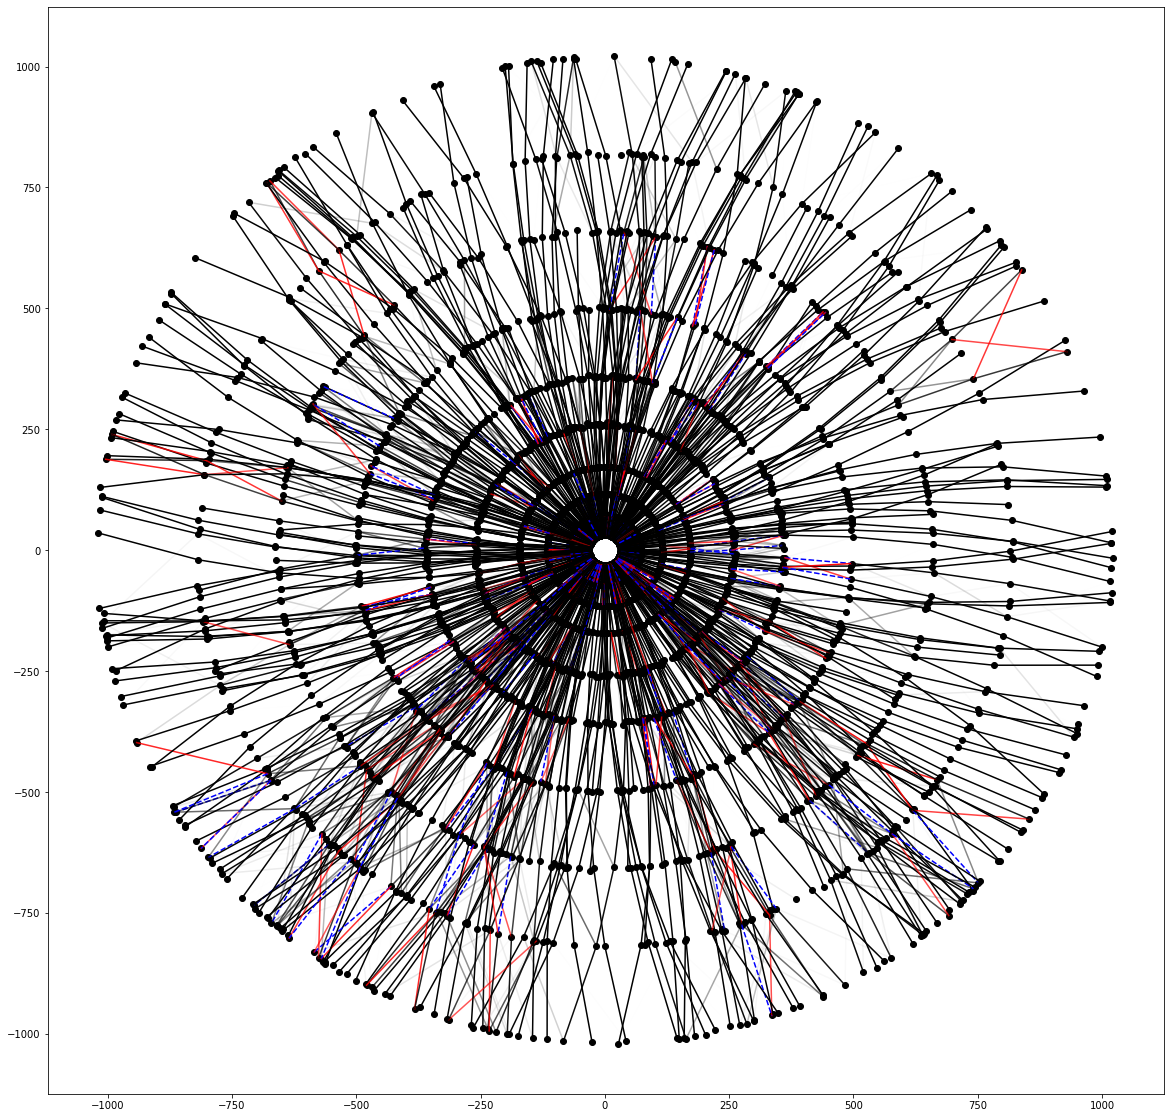

In [38]:
data = test_loader.dataset[0].to(device)
preds = torch.sigmoid(model(data)).to('cpu')
plot_trackml_classified(data.to('cpu'), preds, feature_scale, cut = 0.6)

### The Attention mechanism in a GNN

The MPNN is working pretty well. Let's try and do better with a more sophisticated convolution function. Essentially, we run the classification network in every iteration, and use the score to weight how the node features are aggregated. In this way, the graph should learn what "attention" it gives to each edge connected to each node. We thus call it an Attention GNN (AGNN). Its model is given by

In [0]:
class EdgeNetwork(nn.Module):
    """
    A module which computes weights for edges of the graph.
    For each edge, it selects the associated nodes' features
    and applies some fully-connected network layers with a final
    sigmoid activation.
    """
    def __init__(self, input_dim, hidden_dim=8, hidden_activation='Tanh',
                 layer_norm=True):
        super(EdgeNetwork, self).__init__()
        self.network = make_mlp(input_dim*2,
                                [hidden_dim, hidden_dim, hidden_dim, 1],
                                hidden_activation=hidden_activation,
                                output_activation=None,
                                layer_norm=layer_norm)

    def forward(self, x, edge_index):
        # Select the features of the associated nodes
        start, end = edge_index
        x1, x2 = x[start], x[end]
        edge_inputs = torch.cat([x[start], x[end]], dim=1)
        return self.network(edge_inputs).squeeze(-1)

class NodeNetwork(nn.Module):
    """
    A module which computes new node features on the graph.
    For each node, it aggregates the neighbor node features
    (separately on the input and output side), and combines
    them with the node's previous features in a fully-connected
    network to compute the new features.
    """
    def __init__(self, input_dim, output_dim=8, hidden_activation='Tanh',
                 layer_norm=True):
        super(NodeNetwork, self).__init__()
        self.network = make_mlp(input_dim*3, [output_dim]*4,
                                hidden_activation=hidden_activation,
                                output_activation=hidden_activation,
                                layer_norm=layer_norm)

    def forward(self, x, e, edge_index):
        start, end = edge_index
        # Aggregate edge-weighted incoming/outgoing features
        mi = scatter_add(e[:, None] * x[start], end, dim=0, dim_size=x.shape[0])
        mo = scatter_add(e[:, None] * x[end], start, dim=0, dim_size=x.shape[0])
        node_inputs = torch.cat([mi, mo, x], dim=1)
        return self.network(node_inputs)

class AGNN_Network(nn.Module):
    """
    Segment classification graph neural network model.
    Consists of an input network, an edge network, and a node network.
    """
    def __init__(self, input_dim=3, hidden_dim=8, n_graph_iters=3,
                 hidden_activation='Tanh', layer_norm=True):
        super(AGNN_Network, self).__init__()
        self.n_graph_iters = n_graph_iters
        # Setup the input network
        self.input_network = make_mlp(input_dim, [hidden_dim],
                                      output_activation=hidden_activation,
                                      layer_norm=layer_norm)
        # Setup the edge network
        self.edge_network = EdgeNetwork(hidden_dim, hidden_dim,
                                        hidden_activation, layer_norm=layer_norm)
        # Setup the node layers
        self.node_network = NodeNetwork(hidden_dim, hidden_dim,
                                        hidden_activation, layer_norm=layer_norm)

    def forward(self, inputs):
        """Apply forward pass of the model"""
        # Apply input network to get hidden representation
        x = self.input_network(inputs.x)
        # Shortcut connect the inputs onto the hidden representation
        # Loop over iterations of edge and node networks
        for i in range(self.n_graph_iters):
            x0 = x
            # Apply edge network
            e = torch.sigmoid(self.edge_network(x, inputs.edge_index))
            # Apply node network
            x = self.node_network(x, e, inputs.edge_index)
            # Add the residual  between iterations
            x = x + x0
        # Apply final edge network
        return self.edge_network(x, inputs.edge_index)

In [0]:
t_loss_v = []
t_acc_v = []
v_loss_v = []
v_acc_v = []
ep = 0

In [41]:
weight = 2
m_configs = {"input_dim": 3, "hidden_dim": 64, "n_graph_iters": 8, "layer_norm": True}
model = AGNN_Network(**m_configs).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-3, amsgrad=True)
for epoch in range(200):
    ep += 1  
    model.train()
    acc, total_loss = train(model, train_loader, optimizer)
    t_loss_v.append(total_loss)
    t_acc_v.append(acc)

    model.eval()
    acc, total_loss = evaluate(model, test_loader)
    v_loss_v.append(total_loss)
    v_acc_v.append(acc)

    print('Epoch: {}, Accuracy: {:.4f}'.format(ep, acc))

Epoch: 1, Accuracy: 0.8170
Epoch: 2, Accuracy: 0.8241
Epoch: 3, Accuracy: 0.8256
Epoch: 4, Accuracy: 0.8291
Epoch: 5, Accuracy: 0.8320
Epoch: 6, Accuracy: 0.8333
Epoch: 7, Accuracy: 0.8383
Epoch: 8, Accuracy: 0.8311
Epoch: 9, Accuracy: 0.8398
Epoch: 10, Accuracy: 0.8392
Epoch: 11, Accuracy: 0.8170
Epoch: 12, Accuracy: 0.8348
Epoch: 13, Accuracy: 0.8504
Epoch: 14, Accuracy: 0.8173
Epoch: 15, Accuracy: 0.8288
Epoch: 16, Accuracy: 0.8348
Epoch: 17, Accuracy: 0.8173
Epoch: 18, Accuracy: 0.9022
Epoch: 19, Accuracy: 0.9265
Epoch: 20, Accuracy: 0.9377
Epoch: 21, Accuracy: 0.9371
Epoch: 22, Accuracy: 0.8366
Epoch: 23, Accuracy: 0.9425
Epoch: 24, Accuracy: 0.9633
Epoch: 25, Accuracy: 0.9382
Epoch: 26, Accuracy: 0.9666
Epoch: 27, Accuracy: 0.9644
Epoch: 28, Accuracy: 0.9700
Epoch: 29, Accuracy: 0.9577
Epoch: 30, Accuracy: 0.9680
Epoch: 31, Accuracy: 0.9705
Epoch: 32, Accuracy: 0.9578
Epoch: 33, Accuracy: 0.9736
Epoch: 34, Accuracy: 0.9722
Epoch: 35, Accuracy: 0.9508
Epoch: 36, Accuracy: 0.9721
E

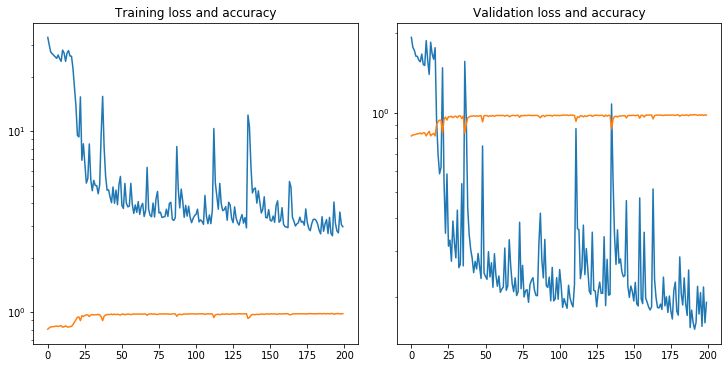

In [42]:
fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(10, 5))
axs[0].plot(np.arange(len(t_loss_v)), t_loss_v, np.arange(len(t_acc_v)), t_acc_v)
axs[0].set_title("Training loss and accuracy")
axs[0].set_yscale("log")
axs[1].plot(np.arange(len(v_loss_v)), v_loss_v, np.arange(len(v_acc_v)), v_acc_v)
axs[1].set_title("Validation loss and accuracy")
axs[1].set_yscale("log")

### Did the AGNN help?

The AGNN is slower to train and infer than the MPNN, but is potentially more accurate. After about 40 epochs with the AGNN, I get over 97% accuracy. With some hyperparameter optimisation, I can get better performance with the AGNN, but if you can make the MPNN out-do the AGNN, let me know!

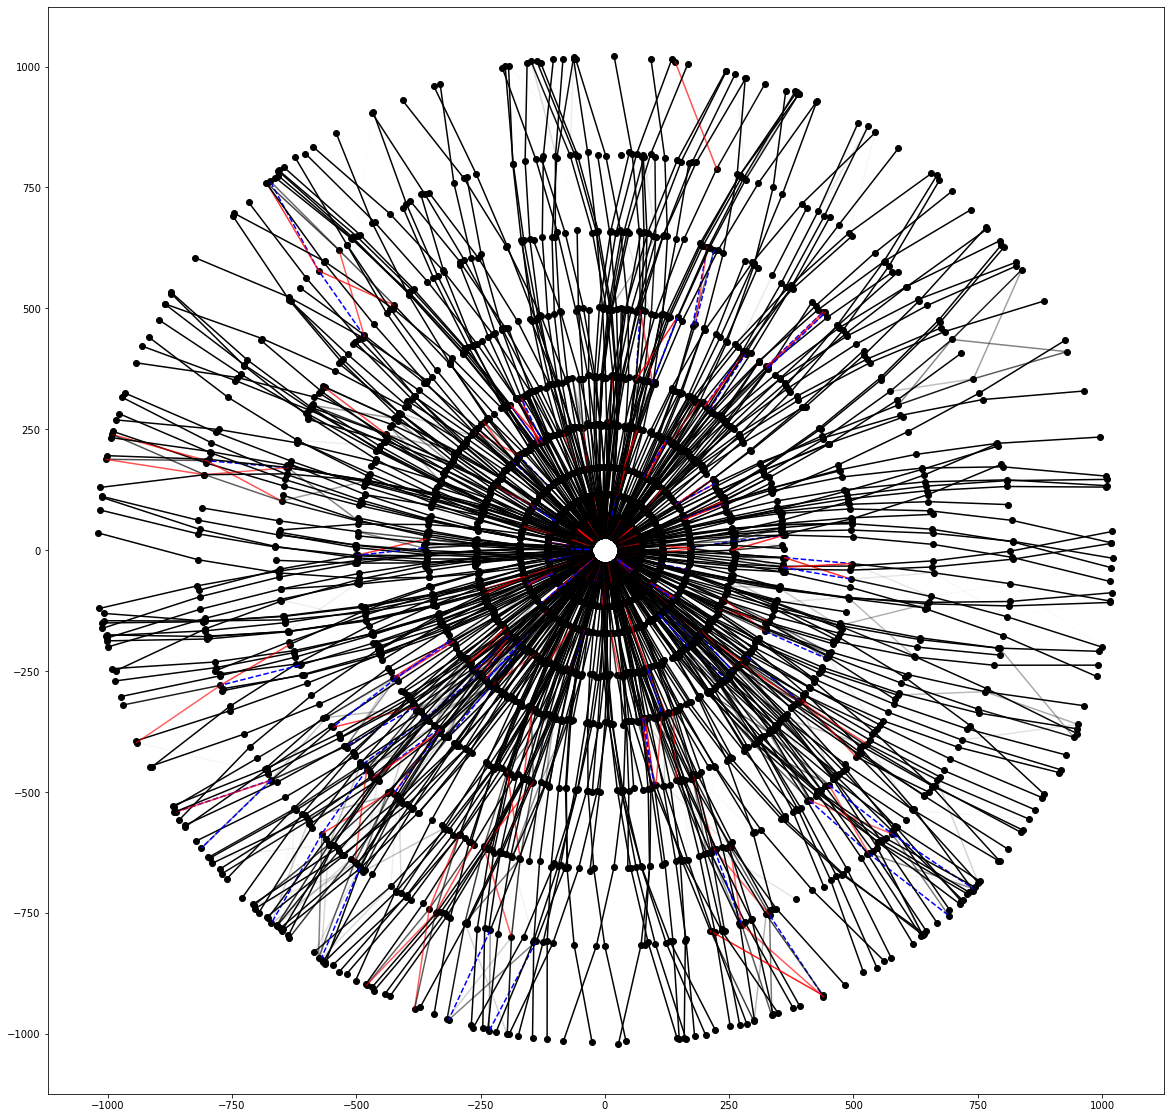

In [43]:
data = test_loader.dataset[0].to(device)
preds = torch.sigmoid(model(data)).to('cpu')
plot_trackml_classified(data.to('cpu'), preds, feature_scale, cut = 0.6)

# **That's all**